In [31]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, FunctionTransformer
from xgboost import XGBRFClassifier, XGBClassifier
from sklearn.ensemble import StackingClassifier
from lightgbm import LGBMClassifier

import warnings
warnings.filterwarnings('ignore')

data = pd.read_csv('training_features.csv')

data['radiant_win'] = pd.read_csv('training_targets.csv')['radiant_win']

In [32]:
# Encode the response variable
label_encoder = LabelEncoder()
data['radiant_win'] = label_encoder.fit_transform(data['radiant_win'])

In [33]:
def get_hero_features(data: pd.DataFrame) -> pd.DataFrame:
    # Load hero data
    hero_data = pd.read_csv('heroes_data.csv').drop(columns=[
        'name', 'img', 'icon', 'base_health', 'base_mana', 
        'base_mr', 'cm_enabled', 'id', 'roles', 'attack_type', 
        'primary_attr', 'main_role', 'localized_name'
    ])

    # Fill missing values
    hero_data['base_health_regen'].fillna(0, inplace=True)

    # Merge hero data for each player
    for team in ['r', 'd']:
        for i in range(1, 6):
            # Add suffix to avoid ambiguity
            hero_data_renamed = hero_data.add_suffix(f'_{team}{i}')
            data = data.merge(hero_data_renamed, 
                              left_on=f'{team}{i}_hero_id', 
                              right_on=f'hero_id_{team}{i}', 
                              how='left')
            # Drop hero_id columns after merge
            data.drop(columns=[f'{team}{i}_hero_id', f'hero_id_{team}{i}'], inplace=True)

    # Define hero attributes to use
    col_to_total = [
        'base_health_regen', 'base_mana_regen', 'base_armor', 'base_attack_min',
        'base_attack_max', 'base_str', 'base_agi', 'base_int', 'str_gain', 
        'agi_gain', 'int_gain', 'attack_range', 'projectile_speed', 
        'attack_rate', 'move_speed', 'winrate'
    ]

    # Aggregate stats and calculate interactions
    for team in ['r', 'd']:
        for col in col_to_total:
            cols = [f'{col}_{team}{i}' for i in range(1, 6)]

            # Aggregates
            data[f'total_{team}_{col}'] = data[cols].sum(axis=1)
            data[f'mean_{team}_{col}'] = data[cols].mean(axis=1)
            data[f'std_{team}_{col}'] = data[cols].std(axis=1)
            data[f'min_{team}_{col}'] = data[cols].min(axis=1)
            data[f'max_{team}_{col}'] = data[cols].max(axis=1)
            data[f'range_{team}_{col}'] = data[f'max_{team}_{col}'] - data[f'min_{team}_{col}']

    # Inter-team comparisons
    for col in col_to_total:
        data[f'{col}_adv'] = data[f'total_r_{col}'] - data[f'total_d_{col}']
        data[f'{col}_ratio'] = (data[f'total_r_{col}'] + 1e-6) / (data[f'total_d_{col}'] + 1e-6)

    # Team scaling potential
    for team in ['r', 'd']:
        data[f'{team}_total_scaling_potential'] = data[f'total_{team}_str_gain'] + \
                                                 data[f'total_{team}_agi_gain'] + \
                                                 data[f'total_{team}_int_gain']

    # Removed unamed 0 columns
    data = data.loc[:, ~data.columns.str.contains('^Unnamed')]

    return data.copy()


In [34]:
def feature_generator(data):
    created_features = {}

    # Keep specific columns
    keep_cols = [
        'game_mode', 'lobby_type', 'r1_hero_id', 'd1_hero_id',
        'r2_hero_id', 'd2_hero_id', 'r3_hero_id', 'd3_hero_id',
        'r4_hero_id', 'd4_hero_id', 'r5_hero_id', 'd5_hero_id'
    ]

    created_features = {col: data[col] for col in keep_cols}

    # Team-level stats
    team_stats = [
        'kills', 'deaths', 'assists', 'denies', 'gold', 'xp', 'lh',
        'creeps_stacked', 'camps_stacked', 'rune_pickups',
        'towers_killed', 'roshans_killed', 'obs_placed', 'sen_placed'
    ]

    for team in ['r', 'd']:
        for stat in team_stats:
            cols = [f'{team}{i}_{stat}' for i in range(1, 6)]
            feat = f'{team}_total_{stat}'
            created_features[feat] = data[cols].sum(axis=1)

    # Game time
    game_time = data['game_time'].replace(0, 1e-4)
    created_features['game_time'] = game_time

    # Team Differences
    for team in ['r', 'd']:
        for stat in team_stats:
            cols = [f'{team}{i}_{stat}' for i in range(1, 6)]
            created_features[f'{team}_mean_{stat}'] = data[cols].mean(axis=1)
            created_features[f'{team}_std_{stat}'] = data[cols].std(axis=1)

    # Per second stats
    for team in ['r', 'd']:
        for stat in team_stats:
            created_features[f'{team}_{stat}_per_sec'] = created_features[f'{team}_total_{stat}'] / game_time

    # Inter-team comparisons
    for stat in team_stats:
        created_features[f'{stat}_advantage'] = created_features[f'r_total_{stat}'] - created_features[f'd_total_{stat}']
        created_features[f'{stat}_sum'] = created_features[f'r_total_{stat}'] + created_features[f'd_total_{stat}']
        created_features[f'{stat}_ratio'] = (created_features[f'r_total_{stat}'] + 1e-6) / (created_features[f'd_total_{stat}'] + 1e-6)

    # Player-level KDA
    for team in ['r', 'd']:
        for i in range(1, 6):
            kills = data[f'{team}{i}_kills']
            deaths = data[f'{team}{i}_deaths']
            assists = data[f'{team}{i}_assists']
            last_hits = data[f'{team}{i}_lh']
            feat = f'{team}{i}_kd_ratio'
            created_features[feat] = (kills + assists + last_hits) / (deaths + 1e-4)

    # Positional features
    for team in ['r', 'd']:
        x = np.array([data[f'{team}{i}_x'] for i in range(1, 6)])
        y = np.array([data[f'{team}{i}_y'] for i in range(1, 6)])
        created_features[f'{team}_mean_x'] = x.mean(axis=0)
        created_features[f'{team}_mean_y'] = y.mean(axis=0)
        created_features[f'{team}_spread'] = np.sqrt(x.std(axis=0)**2 + y.std(axis=0)**2)

    created_features['spread_advantage'] = created_features['r_spread'] - created_features['d_spread']

    # Efficiency and advantage metrics
    created_features["r_xp_to_gold_ratio"] = created_features["r_total_xp"] / (created_features["r_total_gold"] + 1e-6)
    created_features["d_xp_to_gold_ratio"] = created_features["d_total_xp"] / (created_features["d_total_gold"] + 1e-6)
    created_features["r_gold_to_xp_ratio"] = 1 / (created_features["r_xp_to_gold_ratio"] + 1e-6)
    created_features["d_gold_to_xp_ratio"] = 1 / (created_features["d_xp_to_gold_ratio"] + 1e-6)

    created_features["r_kill_participation"] = created_features["r_total_assists"] / (created_features["r_total_kills"] + 1e-4)
    created_features["d_kill_participation"] = created_features["d_total_assists"] / (created_features["d_total_kills"] + 1e-4)
    created_features["kill_participation_advantage"] = created_features["r_kill_participation"] - created_features["d_kill_participation"]

    created_features["r_lh_denies_per_sec"] = (created_features["r_total_lh"] + created_features["r_total_denies"]) / game_time
    created_features["d_lh_denies_per_sec"] = (created_features["d_total_lh"] + created_features["d_total_denies"]) / game_time

    # Objective control
    created_features['r_objective_control'] = created_features['r_total_towers_killed'] + 2 * created_features['r_total_roshans_killed']
    created_features['d_objective_control'] = created_features['d_total_towers_killed'] + 2 * created_features['d_total_roshans_killed']
    created_features['objective_control_advantage'] = created_features['r_objective_control'] - created_features['d_objective_control']

    # Vision
    created_features['r_vision_score'] = created_features['r_total_obs_placed'] + created_features['r_total_sen_placed']
    created_features['d_vision_score'] = created_features['d_total_obs_placed'] + created_features['d_total_sen_placed']
    created_features['vision_score_advantage'] = created_features['r_vision_score'] - created_features['d_vision_score']

    # Momentum and scaling
    created_features['momentum_kills'] = created_features['r_total_kills'] - created_features['d_total_kills']
    created_features['momentum_gold'] = created_features['r_gold_per_sec'] - created_features['d_gold_per_sec']
    created_features['scaling_potential'] = created_features['r_total_xp'] - created_features['d_total_xp']

    # Combined features
    created_features['map_control_advantage'] = created_features['objective_control_advantage'] + created_features['vision_score_advantage']
    created_features['fight_potential_advantage'] = created_features['momentum_kills'] + created_features['scaling_potential']

    # Convert created features dict to DataFrame
    return pd.DataFrame(created_features)



In [35]:
def sanitize_column_names(df):
    df.columns = (
        df.columns.str.replace('[^A-Za-z0-9_]+', '_', regex=True)
                  .str.replace('__+', '_', regex=True)
                  .str.strip('_')
    )
    return df


In [36]:
# ----- Feature engineering -----
filtered_data = feature_generator(data)
filtered_data = get_hero_features(filtered_data)

# Separate features and target
features = filtered_data
response = data['radiant_win']

# Split data into train and test
X_train, X_test, y_train, y_test = train_test_split(
    features, response, test_size=0.3, stratify=response, random_state=86
)

# Define categorical columns to encode
categorical_cols = ['game_mode', 'lobby_type']

# Create column transformer for OneHotEncoding categorical columns
oencoder = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols),
        ('num', StandardScaler(), features.columns.difference(categorical_cols)),
    ],
    remainder='passthrough',
    verbose_feature_names_out=False
)

# Fit encoder on training data
oencoder.fit(X_train)

# Transform both train and test sets
X_train_encoded = oencoder.transform(X_train)
X_test_encoded = oencoder.transform(X_test)

# Get transformed column names
encoded_feature_names = oencoder.get_feature_names_out()

# Convert encoded data to DataFrames and align index
X_train = pd.DataFrame(
    X_train_encoded, columns=encoded_feature_names, index=X_train.index)
X_test = pd.DataFrame(
    X_test_encoded, columns=encoded_feature_names, index=X_test.index)

X_train = sanitize_column_names(X_train)
X_test = sanitize_column_names(X_test)

# Show class balance (optional)
print(f'Train Value Counts:\n{y_train.value_counts()}')
print(f'Test Value Counts:\n{y_test.value_counts()}')



Train Value Counts:
radiant_win
1    10896
0     9876
Name: count, dtype: int64
Test Value Counts:
radiant_win
1    4670
0    4233
Name: count, dtype: int64


In [37]:
from sklearn.feature_selection import SelectFromModel

# Train a model for feature importance
feature_select = SelectFromModel(
    XGBClassifier(random_state=86, use_label_encoder=False, eval_metric='aucpr'),
    threshold="mean",
    prefit=False,
)

# Fit feature selector
feature_select.fit(X_train, y_train)

# Get support mask (True = selected)
support = feature_select.get_support()

# Get selected feature names
top_features = X_train.columns[support].tolist()

# Save selected features
with open('features_to_keep.txt', 'w') as f:
    for feature in top_features:
        f.write(f"{feature}\n")

# Transform train/test sets to select only those features
X_train = pd.DataFrame(feature_select.transform(X_train), columns=top_features, index=X_train.index)
X_test = pd.DataFrame(feature_select.transform(X_test), columns=top_features, index=X_test.index)

print(f'Selected Features {top_features}')


Selected Features ['game_mode_23', '1_pick_d1', '1_pick_d3', '1_pick_d4', '1_pick_r2', '1_pick_r4', '1_win_d3', '1_win_d4', '1_win_r1', '1_win_r2', '2_pick_r2', '2_pick_r3', '2_win_d3', '2_win_d4', '2_win_d5', '2_win_r4', '3_pick_d2', '3_pick_d3', '3_pick_d4', '3_pick_d5', '3_pick_r1', '3_pick_r4', '3_pick_r5', '3_win_d1', '3_win_d4', '3_win_r1', '3_win_r3', '3_win_r4', '3_win_r5', '4_pick_d2', '4_pick_d4', '4_pick_r1', '4_pick_r3', '4_win_d3', '4_win_d4', '4_win_d5', '4_win_r2', '4_win_r4', '5_pick_d2', '5_pick_d4', '5_pick_d5', '5_pick_r1', '5_win_d1', '5_win_d4', '5_win_r1', '5_win_r2', '5_win_r3', '5_win_r5', '6_pick_d2', '6_pick_r1', '6_pick_r4', '6_pick_r5', '6_win_d3', '6_win_d5', '6_win_r1', '6_win_r2', '6_win_r5', '7_pick_d1', '7_pick_d2', '7_pick_d3', '7_pick_d5', '7_pick_r1', '7_win_d1', '7_win_d4', '7_win_r1', '7_win_r2', '7_win_r3', '8_pick_d1', '8_pick_d4', '8_pick_r5', '8_win_d2', '8_win_d3', '8_win_d4', '8_win_d5', '8_win_r3', '8_win_r5', 'agi_gain_adv', 'agi_gain_r1', 

Best F1 Score: 0.8108220951108513
Best Threshold: 0.4400000000000003
Train F1 Score: 0.8108220951108513
Test F1 Score: 0.7716381418092909


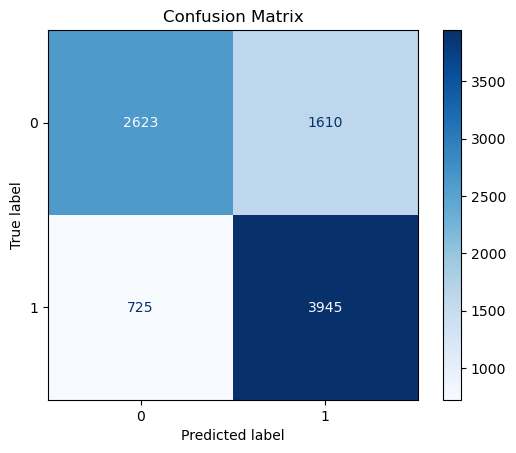

In [38]:
# Stacking Model
estimators = [
    ('xgbrf', XGBRFClassifier(random_state=86)),
    ('ridge', RidgeClassifier(random_state=86)),
    ('lgbm', LGBMClassifier(random_state=86, verbose=-1)),
]


stacking_model = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(random_state=86, max_iter=1000),
    cv=StratifiedKFold(shuffle=True, random_state=86),
    n_jobs=-1,
    passthrough=True,
)


cat_model = CalibratedClassifierCV(
    estimator=stacking_model,
    method='isotonic',
    cv=StratifiedKFold(),
    n_jobs=-1  
)

cat_model.fit(X_train, y_train)

# Print the f1 score for train and test sets
y_train_pred = cat_model.predict_proba(X_train)[:,1]
y_test_pred = cat_model.predict_proba(X_test)[:,1]


# Find the best threshold for F1 score
best_f1 = 0
best_threshold = 0

for i in np.arange(0.1, 0.99, 0.001):
    y_train_pred_binary = (y_train_pred > i).astype(int)
    f1 = f1_score(y_train, y_train_pred_binary)
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = i

# Apply the best threshold to the predictions
y_train_pred = (y_train_pred > best_threshold).astype(int)
y_test_pred = (y_test_pred > best_threshold).astype(int)

# Display results
print(f'Best F1 Score: {best_f1}')
print(f'Best Threshold: {best_threshold}')

train_f1 = f1_score(y_train, y_train_pred)
test_f1 = f1_score(y_test, y_test_pred)
print(f'Train F1 Score: {train_f1}')
print(f'Test F1 Score: {test_f1}')

proba = cat_model.predict_proba(X_test)[:, 1]
cm = confusion_matrix(y_test, (proba > best_threshold).astype(int))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=cat_model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# Retrain the model on the entire dataset
features_encoded = oencoder.transform(features)
features = pd.DataFrame(
    features_encoded, columns=encoded_feature_names, index=features.index)
features = features[top_features]
features = sanitize_column_names(features)

cat_model.fit(features, response)

# Save the model
with open('stacking_model_final.pkl', 'wb') as f:
    pickle.dump(cat_model, f)

In [39]:
# Read in the features to keep
with open('features_to_keep.txt', 'r') as f:
    features_to_keep = [line.strip() for line in f.readlines()]

# Load validation dataset
validation_data = pd.read_csv('test_features.csv')

# Apply preprocessing
processed_validation_data = feature_generator(validation_data)
processed_validation_data = get_hero_features(processed_validation_data)

val_encoded = oencoder.transform(processed_validation_data)

processed_validation_data = pd.DataFrame(
    val_encoded, columns=encoded_feature_names, index=validation_data.index)

processed_validation_data = processed_validation_data[features_to_keep]
processed_validation_data = sanitize_column_names(processed_validation_data)

# Predict probabilities
validation_pred = cat_model.predict_proba(processed_validation_data)[:, 1]
validation_pred = (validation_pred > best_threshold).astype(int)

# Display prediction counts
print("Prediction counts:")
print(pd.Series(validation_pred).value_counts())

# Prepare submission DataFrame
results = pd.DataFrame({
    'match_id_hash': validation_data['match_id_hash'],
    'radiant_win': label_encoder.inverse_transform(validation_pred)
})

# Save submission
results.to_csv('submission.csv', index=False)
print("Submission file saved as submission.csv.")

# Display submission info
results.info()

Prediction counts:
1    6245
0    3755
Name: count, dtype: int64
Submission file saved as submission.csv.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   match_id_hash  10000 non-null  object
 1   radiant_win    10000 non-null  bool  
dtypes: bool(1), object(1)
memory usage: 88.0+ KB
